# Solving the Hamiltonian Path
## Definition and Purpose

Let $G=(V,E)$ be a graph where $V$ is a set of vertices and $E$ is a set of edges. A Hamiltonian Path is a path in $G$ that visits every vertex exactly once.

Formally, we seek a permutation $P=(v1​,v2​,…,vn​)$ of the vertices in $V$ such that for every adjacent pair of vertices in the sequence, an edge exists in the graph:
$$(vi​,vi+1​)∈E∀1≤i<n$$

No efficient polynomial-time algorithm is known to solve it for general graphs, necessitating the use of metaheuristics for larger instances. Importantly, the Hamiltonian path is critical for de novo genome assembly, where the goal is to reconstruct a single continuous DNA sequence by ordering overlapping fragments (reads) such that each fragment is visited exactly once.

## Strategy and Implementation 

I approach the problem using three metaheuristic approaches: Genetic Algorithms, Simulated Annealing, and Tabu Search. However, the provided course scripts (ga.py, sa.py, tabu.py) are designed for discrete optimisation problems, and standard discrete optimisation operators (bit-flipping, array slicing) are destructive, in the case of permutations (i.e. Hamiltonian path). As such, I have tried to **re-write** the course material scripts in order to better appropriate them for the problem I am trying to solve.

**Swap Mutation** and **Ordered Crossover (OX1)** are introduced later in my scripts to make the algorithms work and score correctly; which are otherwise absent in the original course material scripts.

### Specifically:

- **Generated Graph**: 50 Nodes, 30% edge probability (Erdős-Rényi)
- **Goal**: Minimise the number of "broken" (non-existent) edges in the path. Target Cost = 0

## Setup

Importing course material modules and libraries

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from math import exp, floor

# --- PROBLEM SETUP ---
NUM_NODES = 50
# Use a fixed seed for reproducibility
G = nx.erdos_renyi_graph(n=NUM_NODES, p=0.3, seed=42)
NODES = list(G.nodes)

def get_initial_solution():
    """Returns a random permutation of nodes."""
    p = NODES.copy()
    random.shuffle(p)
    return p

# --- FITNESS FUNCTIONS ---

def count_edges(path):
    """Counts valid edges in the path."""
    edges = 0
    for i in range(len(path) - 1):
        if G.has_edge(path[i], path[i+1]):
            edges += 1
    return edges

# Minimisation Objective (Used by SA & Tabu)
# Lower is better. 0 = Success.
def fitness_min(path):
    target = len(path) - 1
    valid = count_edges(path)
    return float(target - valid)

# Maximisation Objective (Used by GA)
# Higher is better. Target = NUM_NODES - 1
def fitness_max(path):
    return float(count_edges(path))

## Helper Functions (Moves and Neighbourhoods)
Simulated Annealing and Tabu search require a "move" or "neighbourhood" concept, this will help with the permutations.

In [9]:
def random_swap(path):
    """Returns a NEW path with two random nodes swapped (for SA)."""
    new_path = path.copy()
    i, j = random.sample(range(len(path)), 2)
    new_path[i], new_path[j] = new_path[j], new_path[i]
    return new_path

def get_neighborhood(path):
    """
    Returns a list of neighbors for Tabu.
    Instead of just adjacent swaps, we sample 50 random swaps 
    to allow larger jumps across the solution space.
    """
    neighbors = []
    # Generate 50 random neighbors (stochastic hill climbing)
    # This prevents being trapped by the "only adjacent" restriction
    for _ in range(50):
        neighbors.append(random_swap(path))
    return neighbors

## Fitness Functions

As mentioned in the introductory segment, the libraries differ in optimisation direction, so I attempt to implement two versions.

    Goal: A path with N−1 valid edges.

    Minimisation (SA/Tabu): Cost = Number of missing edges. Ideal = 0.

    Maximisation (GA): Fitness = Number of existing edges. Ideal = N−1.

In [10]:
# --- REFINED FITNESS FUNCTIONS ---

def count_edges(path):
    """Counts valid edges in the path."""
    edges = 0
    for i in range(len(path) - 1):
        if G.has_edge(path[i], path[i+1]):
            edges += 1
    return edges

# Minimisation (SA & Tabu): Unchanged
def fitness_min(path):
    target = len(path) - 1
    valid = count_edges(path)
    return float(target - valid)

# Maximisation (GA): LINEAR (Reverted)
# We revert to simple edge counting. Target is NUM_NODES - 1.
def fitness_max(path):
    return float(count_edges(path))

## Simulated Annealing 

In [11]:
def run_simulated_annealing(max_steps=1000, temp0=100.0):
    print("Running Simulated Annealing...")
    
    current = get_initial_solution()
    best = current.copy()
    
    current_cost = fitness_min(current)
    best_cost = current_cost
    
    trace = []
    temp = temp0
    
    for step in range(max_steps):
        # 1. Log Trace
        trace.append(best_cost)
        
        # 2. Stop Condition
        if best_cost == 0:
            print(f"SA Success at step {step}!")
            break
            
        # 3. Create Neighbor (Random Swap)
        neighbor = current.copy()
        i, j = random.sample(range(len(neighbor)), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        
        neighbor_cost = fitness_min(neighbor)
        
        # 4. Acceptance Probability
        delta = neighbor_cost - current_cost
        
        if delta < 0 or random.random() < exp(-delta / temp):
            current = neighbor
            current_cost = neighbor_cost
            
            # Update Best
            if current_cost < best_cost:
                best = current.copy()
                best_cost = current_cost
        
        # 5. Cooling (Geometric) - previous runs it failed with 0.99
        temp *= 0.985
        
    return best, trace

## Tabu Search 

In [12]:
def run_tabu_search(max_steps=1000, tenure=20):
    print("Running Tabu Search...")
    
    current = get_initial_solution()
    best = current.copy()
    
    best_cost = fitness_min(best)
    
    tabu_list = []
    trace = []
    
    for step in range(max_steps):
        # 1. Log Trace
        trace.append(best_cost)
        
        # 2. Stop Condition
        if best_cost == 0:
            print(f"Tabu Success at step {step}!")
            break
            
        # 3. Generate Neighborhood (50 Random Swaps)
        # This is 'Stochastic Hill Climbing' within Tabu
        candidates = []
        for _ in range(50):
            candidate = current.copy()
            i, j = random.sample(range(len(candidate)), 2)
            candidate[i], candidate[j] = candidate[j], candidate[i]
            
            # Record move signature (simple tuple of sorted indices) to verify Tabu status
            # Note: For strict Tabu, we usually ban specific moves. 
            # Here we just check if the resulting solution is physically in the list (simplified)
            candidates.append(candidate)
            
        # 4. Select Best Non-Tabu Move
        # Sort by fitness (lowest cost first)
        candidates.sort(key=fitness_min)
        
        found_move = False
        for cand in candidates:
            cand_cost = fitness_min(cand)
            
            # Aspiration Criteria: If it's better than global best, ignore Tabu list
            if cand_cost < best_cost:
                current = cand
                best = cand
                best_cost = cand_cost
                found_move = True
                break
            
            # Otherwise, check Tabu list
            if cand not in tabu_list:
                current = cand
                found_move = True
                break
        
        # 5. Update Tabu List
        if found_move:
            tabu_list.append(current)
            if len(tabu_list) > tenure:
                tabu_list.pop(0)

    return best, trace

## Genetic Algorithm (Patched)

In [13]:
def run_genetic_algorithm(pop_size=200, generations=1000, cross_rate=0.8, mut_rate=0.3):
    print("Running Genetic Algorithm...")
    
    # --- Helper Operators ---
    def ordered_crossover(p1, p2):
        """Permutation-safe Crossover (OX1)"""
        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[start:end] = p1[start:end]
        
        current_p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while p2[current_p2_idx] in child:
                    current_p2_idx += 1
                child[i] = p2[current_p2_idx]
        return child

    def swap_mutation(genome):
        """Permutation-safe Mutation"""
        i, j = random.sample(range(len(genome)), 2)
        genome[i], genome[j] = genome[j], genome[i]
        return genome

    # --- Initialization ---
    population = [get_initial_solution() for _ in range(pop_size)]
    trace = []
    
    for gen in range(generations):
        # 1. Evaluate
        # We calculate fitness for everyone. Note: GA uses MAXIMISATION here.
        fitnesses = [fitness_max(p) for p in population]
        best_val = max(fitnesses)
        
        # Convert to minimization metric for the trace (Broken Edges)
        target = NUM_NODES - 1
        current_broken = target - best_val
        trace.append(current_broken)
        
        if current_broken == 0:
            print(f"GA Success at generation {gen}!")
            break
            
        # 2. Selection (Tournament)
        next_pop = []
        # Keep the absolute best (Elitism)
        best_idx = fitnesses.index(best_val)
        next_pop.append(population[best_idx])
        
        while len(next_pop) < pop_size:
            # Tournament of size 3
            competitors = random.sample(population, 3)
            winner = max(competitors, key=fitness_max)
            next_pop.append(winner)
            
        population = next_pop

        # 3. Crossover
        # We process the list in pairs
        for i in range(1, pop_size - 1, 2):
            if random.random() < cross_rate:
                p1 = population[i]
                p2 = population[i+1]
                # Create two children
                c1 = ordered_crossover(p1, p2)
                c2 = ordered_crossover(p2, p1)
                population[i] = c1
                population[i+1] = c2
                
        # 4. Mutation
        for i in range(1, pop_size): # Skip elite at index 0
            if random.random() < mut_rate:
                population[i] = swap_mutation(population[i])
                
    # Return best found
    final_fitnesses = [fitness_max(p) for p in population]
    best_idx = final_fitnesses.index(max(final_fitnesses))
    return population[best_idx], trace

## Visualise

Running Simulated Annealing...
Running Tabu Search...
Tabu Success at step 619!
Running Genetic Algorithm...
GA Success at generation 501!


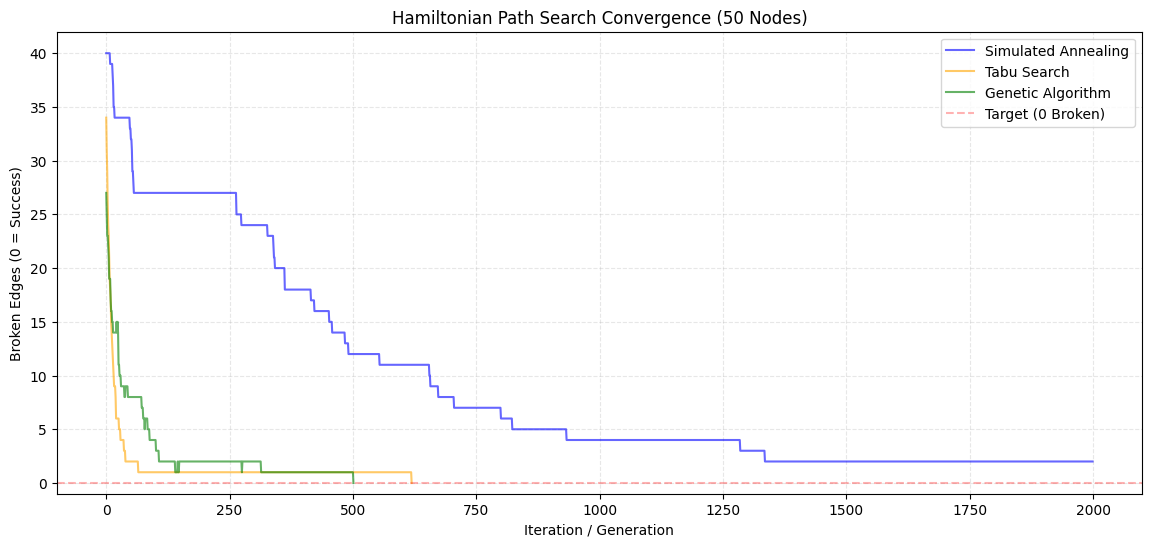

,Algorithm,Success,Final Broken Edges,Iterations to Best
0,Simulated Annealing,False,2,2000
1,Tabu Search,True,0,620
2,Genetic Algorithm,True,0,502


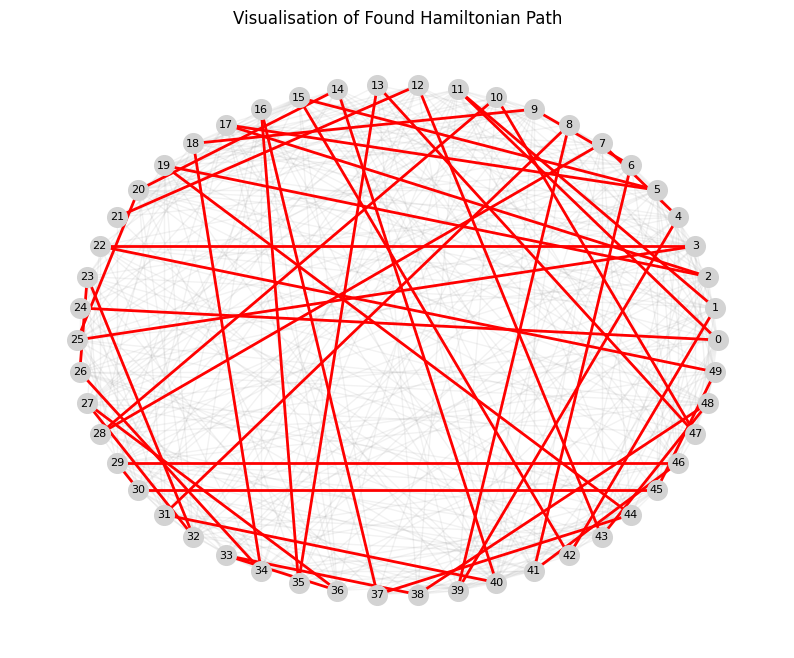

In [14]:
# --- EXECUTION ---
# 1. SA
best_sa, trace_sa = run_simulated_annealing(max_steps=2000)

# 2. Tabu
best_tabu, trace_tabu = run_tabu_search(max_steps=2000, tenure=30)

# 3. GA
# With linear fitness, we might need a slightly higher mutation rate to avoid stagnation
best_ga, trace_ga = run_genetic_algorithm(generations=2000, pop_size=200, mut_rate=0.4)

# --- 2. PLOTTING CONVERGENCE ---
plt.figure(figsize=(14, 6))
plt.plot(trace_sa, label='Simulated Annealing', color='blue', alpha=0.6, linewidth=1.5)
plt.plot(trace_tabu, label='Tabu Search', color='orange', alpha=0.6, linewidth=1.5)
plt.plot(trace_ga, label='Genetic Algorithm', color='green', alpha=0.6, linewidth=1.5)

plt.title(f"Hamiltonian Path Search Convergence ({NUM_NODES} Nodes)")
plt.xlabel("Iteration / Generation")
plt.ylabel("Broken Edges (0 = Success)")
plt.axhline(0, color='red', linestyle='--', alpha=0.3, label='Target (0 Broken)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(bottom=-1)
plt.show()

# --- 3. RESULTS TABLE ---
results_data = {
    "Algorithm": ["Simulated Annealing", "Tabu Search", "Genetic Algorithm"],
    "Success": [trace_sa[-1] == 0, trace_tabu[-1] == 0, trace_ga[-1] == 0],
    "Final Broken Edges": [int(trace_sa[-1]), int(trace_tabu[-1]), int(trace_ga[-1])],
    "Iterations to Best": [len(trace_sa), len(trace_tabu), len(trace_ga)]
}
df_results = pd.DataFrame(results_data)
display(df_results)

# --- 4. VISUALISING THE BEST PATH ---
successful_path = None
# Check for success (Cost 0 for SA/Tabu, or Edges = N-1 for GA)
if fitness_min(best_tabu) == 0: successful_path = best_tabu
elif fitness_min(best_sa) == 0: successful_path = best_sa
elif count_edges(best_ga) == (NUM_NODES - 1): successful_path = best_ga

if successful_path:
    plt.figure(figsize=(10, 8))
    pos = nx.circular_layout(G)
    
    # Draw background
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightgrey')
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='grey')
    
    # Draw Solution Path
    path_edges = []
    for i in range(len(successful_path)-1):
        u, v = successful_path[i], successful_path[i+1]
        path_edges.append((u, v))
        
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Visualisation of Found Hamiltonian Path")
    plt.axis('off')
    plt.show()
else:
    print("No perfect Hamiltonian Path found to visualize.")